In [3]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
import intake

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline


# CESM

In [7]:
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)
catalog_subset = catalog.search(variable=['U', "V"], frequency="daily", forcing_variant="cmip6")
dsets = catalog_subset.to_dataset_dict(storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


Increasing number of chunks by factor of 49


In [8]:
historical_cmip6 = dsets['atm.historical.daily.cmip6']
future_cmip6 = dsets['atm.ssp370.daily.cmip6']

In [ ]:
def standardize(ds):
    ds = ds.rename({"U": "u", "V": "v"})
    ds["u"] = ds["u"].astype(np.float16)
    ds["u"] = ds["u"].astype(np.float16)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.sortby("lon")
    ds = ds.sortby("lat")
    ds["s"] = np.sqrt(ds["u"] ** 2 + ds["v"] ** 2)
    return ds.unify_chunks()

merge_ds_cmip6= xr.concat([standardize(historical_cmip6), standardize(future_cmip6)], dim='time')
merge_ds_cmip6['time'] = merge_ds_cmip6.indexes['time'].to_datetimeindex()

In [ ]:
def flatten_by(ds: xr.Dataset, by: str = "-criterion") -> xr.Dataset:
    if "lev" not in ds.dims:
        return ds
    ope = np.nanargmin if by[0] == "-" else np.nanargmax
    by = by.lstrip("-")
    levmax = ds[by].reduce(ope, dim="lev")
    ds = ds.isel(lev=levmax).reset_coords("lev")  # but not drop
    ds["lev"] = ds["lev"].astype(np.float32)
    return ds


template = merge_ds_cmip6.isel(lev=0).reset_coords("lev", drop=True)
template["lev"] = template["u"]
flattened = xr.map_blocks(flatten_by, merge_ds_cmip6, kwargs=dict(by="s"), template=template)

# Daskify

In [4]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
# exp = MultiVarExperiment(data_handlers)

# all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()

In [5]:
ds = xr.Dataset({varname: dh.da.astype(np.float32) for varname, dh in data_handlers.items()})

In [13]:
def flatten_by(ds: xr.Dataset, by: str = "-criterion") -> xr.Dataset:
    if "lev" not in ds.dims:
        return ds
    ope = np.nanargmin if by[0] == "-" else np.nanargmax
    by = by.lstrip("-")
    levmax = ds[by].reduce(ope, dim="lev")
    ds = ds.isel(lev=levmax).reset_coords("lev")  # but not drop
    ds["lev"] = ds["lev"].astype(np.float32)
    return ds


def preprocess(ds: xr.Dataset, smooth_s: float = None) -> xr.Dataset:
    ds = flatten_by(ds, "s")
    ds = coarsen_da(ds, 1.5)
    if smooth_s is not None:
        for var in ["u", "v", "s"]:
            ds[var] = smooth(ds[var], smooth_map={"lon+lat": ("fft", smooth_s)})
    ds = ds.assign_coords(
        {
            "x": np.radians(ds["lon"]) * RADIUS,
            "y": RADIUS
            * np.log(
                (1 + np.sin(np.radians(ds["lat"])) / np.cos(np.radians(ds["lat"])))
            ),
        }
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        ds["sigma"] = (
            ds["u"] * ds["s"].differentiate("y") - ds["v"] * ds["s"].differentiate("x")
        ) / ds["s"]
    fft_smoothing = 1.0 if ds["sigma"].min() < -0.0001 else 0.8
    ds["sigma"] = smooth(ds["sigma"], smooth_map={"lon+lat": ("fft", fft_smoothing)})
    return ds.reset_coords(["x", "y"], drop=True)


def find_jets(
    ds: xr.Dataset,
    wind_threshold: float = 23,
    jet_threshold: float = 1.0e8,
    alignment_threshold: float = 0.3,
    mean_alignment_threshold: float = 0.7,
    smooth_s: float = 0.3,
    hole_size: int = 1,
):
    if "threshold" in ds:
        wind_threshold = ds["threshold"].item()
        jet_threshold = jet_threshold * ds["threshold_ratio"].item()
    ds = preprocess(ds, smooth_s=smooth_s)
    lon, lat = ds.lon.values, ds.lat.values
    dx = lon[1] - lon[0]
    contours, types = contour_generator(
        x=lon, y=lat, z=ds["sigma"].values, line_type="SeparateCode", quad_as_tri=False
    ).lines(0.0)
    groups = []
    for contour, types_ in zip(contours, types):
        if len(contour) < 15:
            continue
        cyclic: bool = 79 in types_
        group = interp_xy_ds(ds, contour[::-1])
        group = compute_alignment(group)
        mask = (group["alignment"] > alignment_threshold) & (
            group["s"].values > wind_threshold
        )
        mask = mask.values
        indicess = get_runs_fill_holes(mask, hole_size=hole_size, cyclic=cyclic)
        for indices in indicess:
            indices = np.unique(indices)
            if len(indices) < 15:
                continue
            try:
                group_df = group.to_dataframe().drop(columns="time").iloc[indices]
            except KeyError:
                group_df = (
                    group.to_dataframe().drop(columns=["ratio", "label"]).iloc[indices]
                )
            group_ = group_df[["lon", "lat"]].values.astype(np.float32)
            labels = (
                AgglomerativeClustering(
                    n_clusters=None, distance_threshold=dx * 1.9, linkage="single"
                )
                .fit(group_)
                .labels_
            )
            masks = labels_to_mask(labels)
            for mask in masks.T:
                groups.append(group_df.iloc[mask])
    jets = []
    for group_df in groups:
        bigjump = np.diff(group_df["lon"]) < -3 * dx
        if any(bigjump):
            here = np.where(bigjump)[0][0] + 1
            group_df = group_df.apply(np.roll, args=(-here,), raw=True)
        group_ = group_df[["lon", "lat", "s"]].values.astype(np.float32)
        jet_int = jet_integral_haversine(group_)
        mean_alignment = np.mean(group_df["alignment"].values)
        if jet_int > jet_threshold and mean_alignment > mean_alignment_threshold:
            jets.append(xr.Dataset.from_dataframe(group_df.reset_index()))
    return xr.concat(jets, dim="jet").drop_vars("points").rename(index="point").astype(np.float32)


def find_all_jets(
    ds: xr.Dataset,
    n_jets: int = 15,
    n_points: int = 230,
    **kwargs,
):
    template = ds.copy()
    template = template.isel(lev=0, lat=0, lon=0).reset_coords(["lev", "lat", "lon"], drop=True)
    template = template.expand_dims({"jet": np.arange(n_jets), "point": np.arange(n_points)}).copy()
    for newvar in ["lev", "sigma", "lon", "lat", "alignment"]:
        template[newvar] = template["s"].copy().astype(np.float32)
    template = template.transpose("time", "jet", "point")

    def inner_find_all_jets(ds_block):
        extra_dims = {}
        for potential in ["time", "member"]:
            if potential in ds_block.dims:
                extra_dims[potential] = ds_block[potential].values
        coords = extra_dims | {"jet": np.arange(n_jets), "point": np.arange(n_points)}
        shape = [len(co) for co in coords.values()]
        template_da = xr.DataArray(np.full(shape, np.nan, dtype=np.float32), coords=coords)
        to_ret = None
        iter_ = product(*list(extra_dims.values()))
        for vals in iter_:
            indexer = {dim: val for dim, val in zip(extra_dims, vals)}
            this_ds = ds_block.loc[indexer]
            these_jets = find_jets(this_ds, **kwargs)
            indexer = indexer | {"jet": these_jets.jet.values, "point": these_jets.point.values}
            if to_ret is None:
                to_ret = xr.Dataset({varname: template_da.copy() for varname in these_jets.data_vars})
            to_ret.loc[indexer] = these_jets
        return to_ret
    
    all_jets_one_ds = xr.map_blocks(inner_find_all_jets, ds, template=template)
    with ProgressBar():
        all_jets_one_ds = all_jets_one_ds.compute(**COMPUTE_KWARGS)

    return all_jets_one_ds

In [14]:
find_all_jets(ds)

[                                        ] | 1% Completed | 297.65 ss



KeyboardInterrupt



In [8]:
n_jets = 15
n_points = 250

template = ds.copy()
template = template.isel(lev=0, lat=0, lon=0).reset_coords(["lev", "lat", "lon"], drop=True)
template = template.expand_dims({"jet": np.arange(n_jets), "point": np.arange(n_points)}).copy()
for newvar in ["lev", "sigma", "lon", "lat", "alignment"]:
    template[newvar] = template["s"].copy().astype(np.float32)
template = template.transpose("time", "jet", "point")

In [9]:
from dask.diagnostics import ProgressBar
all_jets_one_ds = xr.map_blocks(find_all_jets, ds, template=template)
with ProgressBar():
    all_jets_one_ds = all_jets_one_ds.compute(**COMPUTE_KWARGS)

[#                                       ] | 3% Completed | 17m 12sss



KeyboardInterrupt



# Extreme experiment

In [5]:
exp_tp = ExtremeExperiment(
    DataHandler("ERA5", "surf", "tp", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None),
    q = 0.95,
)
da_tp = exp_tp.da.load()

data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
exp = MultiVarExperiment(data_handlers)

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds = exp.props_as_ds(True)

In [28]:
from deepdiff import DeepHash
DeepHash(load_pickle("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/tp/6H/hourofyear_hourofyearwin60/results/1/predictions/1/metadata.pkl"))

{'n_clu': 'f7d339d7242593cf7bacb03b4648e837ae9cd8ce0f70b43f2205848296cf18d6', 11: 'fa26322d0f2ff88344439244a7df169ea50f03fa52ec69ff090791329db4e06f', 'q': 'ee5da069bca4e15d4536ace9d495f182cff455ff5156ad6cb383d41043ad6fe3', 0.95: 'f7d6e1d019c39117d19622ec38491cf2c8a97a485b09091b33645d4099dff124', 'simple': 'f7fdc0e90632355be9e3fd9b0a9ebb265a227b3909a48a09282fb451697b7035', <BoolObj.FALSE: 0>: 'b195620d3676be89da6277412918e9f4e5e2bf23b0eaacfcf674c87609c67f3a', 'minlen': '57c29967c27c63a5330cbe4...}

In [30]:
subset = ["mean_lon", "mean_lat", "mean_lev", "spe_star", "width", "wavinessR16", "persistence", "com_speed", "int"]
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
)
time_before = pd.Timedelta(0, "D")
n_clu = 22
clusters_da = exp_tp.spatial_clusters_as_da(n_clu)
targets, length_targets, all_spells_ts, all_spells = exp_tp.create_targets(n_clu, 0.95, minlen=np.timedelta64(1, "D"))
binary_targets = length_targets > 0
masked_predictors = mask_from_spells_multi_region(predictors, targets, all_spells_ts, all_spells, time_before=time_before)

100%|██████████| 22/22 [00:05<00:00,  4.01it/s]


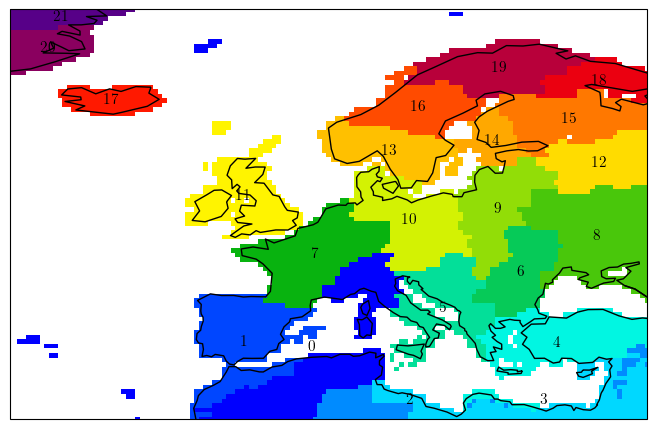

In [31]:
clu = Clusterplot(1, 1, exp_tp.region)
cmap = colormaps.BlAqGrYeOrReVi200
ax = clu.axes[0]
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.unstack().plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(n_clu):
    lo = clusters_da.lon.where(clusters_da==j).mean().item()
    la = clusters_da.lat.where(clusters_da==j).mean().item()
    ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")

In [2]:
compute_all_smoothed_anomalies("ERA5", "plev", "s", "6H", 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)

[########################################] | 100% Completed | 43m 20s


100%|██████████| 768/768 [1:00:00<00:00,  4.69s/it]


In [3]:
compute_all_smoothed_anomalies("ERA5", "surf", "tp", "6H", 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
100%|██████████| 83/83 [02:30<00:00,  1.81s/it]


In [ ]:
basepath = Path(f"{DATADIR}/ERA5/surf")
varnames = ["u10", "v10", "s10"]
for year, month in tqdm(product(YEARS, range(1, 13)), total=len(YEARS) * 12):
    month_str = str(month).zfill(2)
    ofiles = {varname: basepath.joinpath(f"{varname}/6H/{year}{month_str}.nc") for varname in varnames}
    if all([ofile.is_file() for ofile in ofiles.values()]):
        continue
    ds = xr.open_dataset(basepath.joinpath(f"raw/{year}{month_str}.nc"))
    ds = ds.rename(longitude="lon", latitude="lat")
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.sortby("lon")
    ds = ds.sortby("lat")
    ds["s10"] = np.sqrt(ds["u10"] ** 2 + ds["v10"] ** 2)
    for varname in varnames:
        da = ds[varname]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=xr.SerializationWarning)
            da.to_netcdf(ofiles[varname])

  0%|          | 0/768 [00:00<?, ?it/s]

100%|██████████| 768/768 [25:46<00:00,  2.01s/it]
